# Vietoris–Rips: BANGER Visualizations
Below are **embedded previews**. Run the code cells to regenerate or tweak.

**Includes:** VR snapshots, optional persistence diagram + H1 barcode (`ripser`), optional GIF (`imageio`).

**Style:** Matplotlib only, one chart per figure, no explicit colors.


## Previews (already rendered)
**Sparse regime**

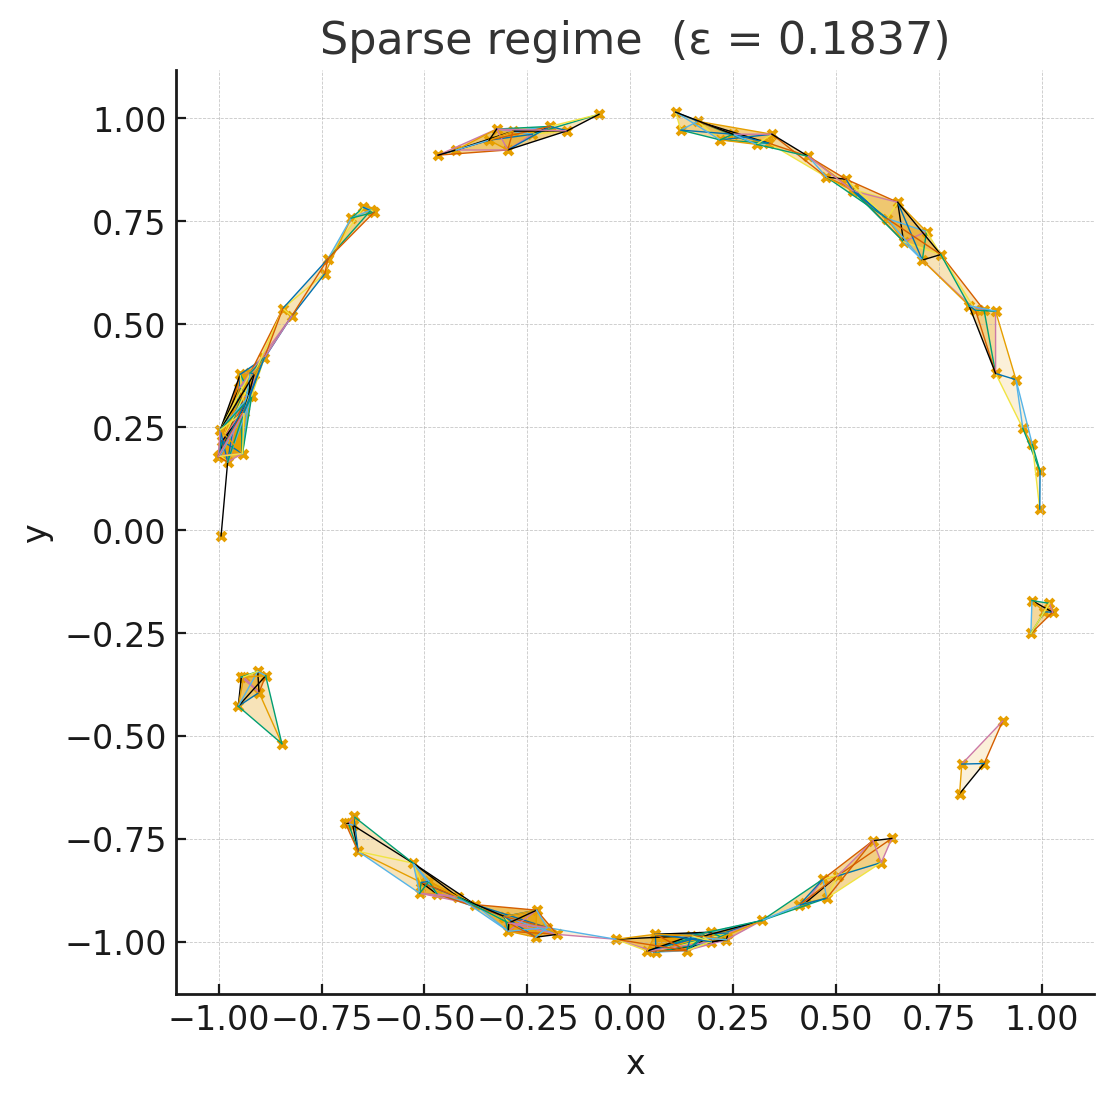

**1-cycle regime**

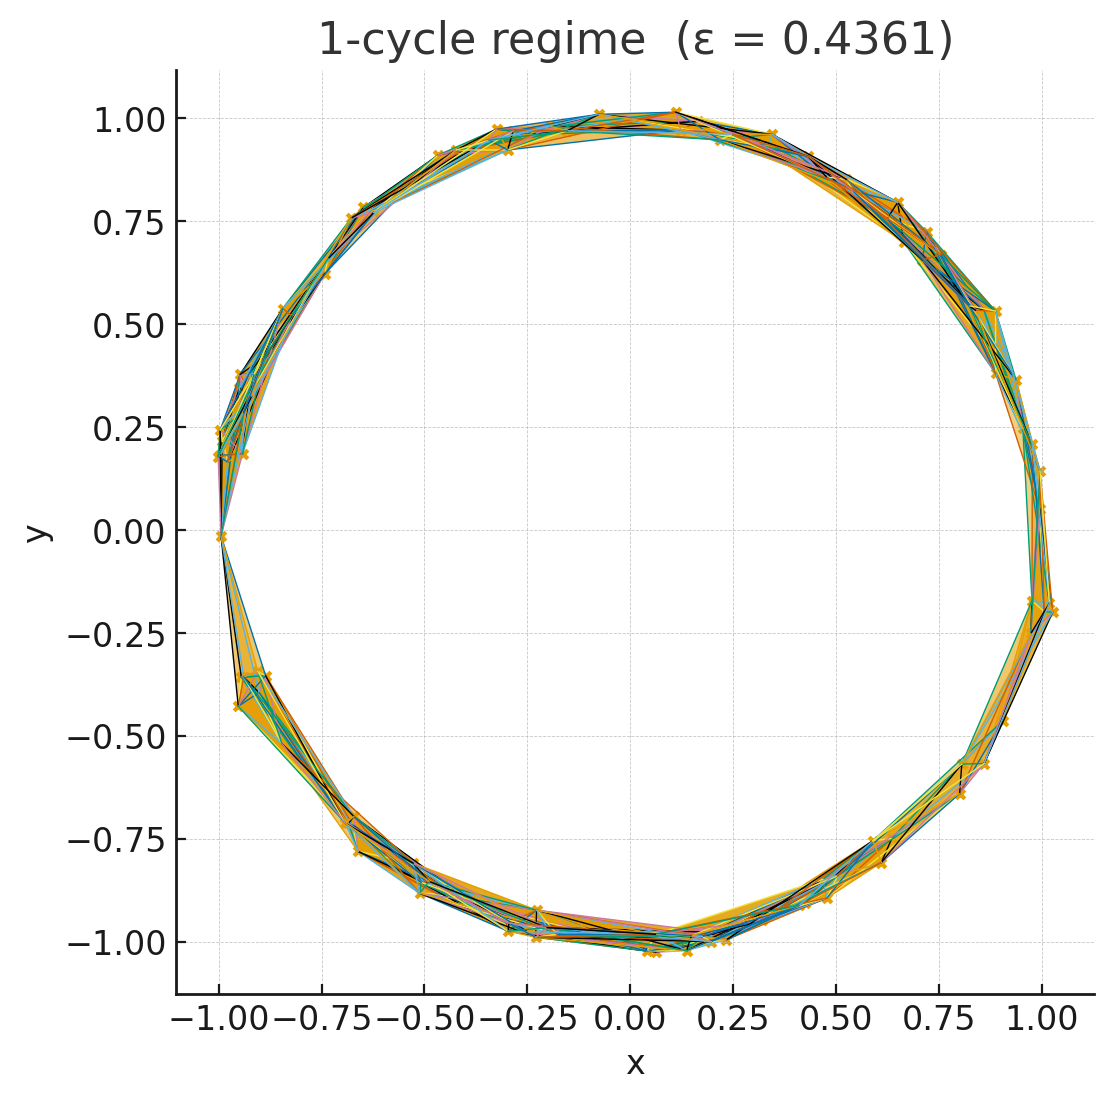

**Filled-in regime**

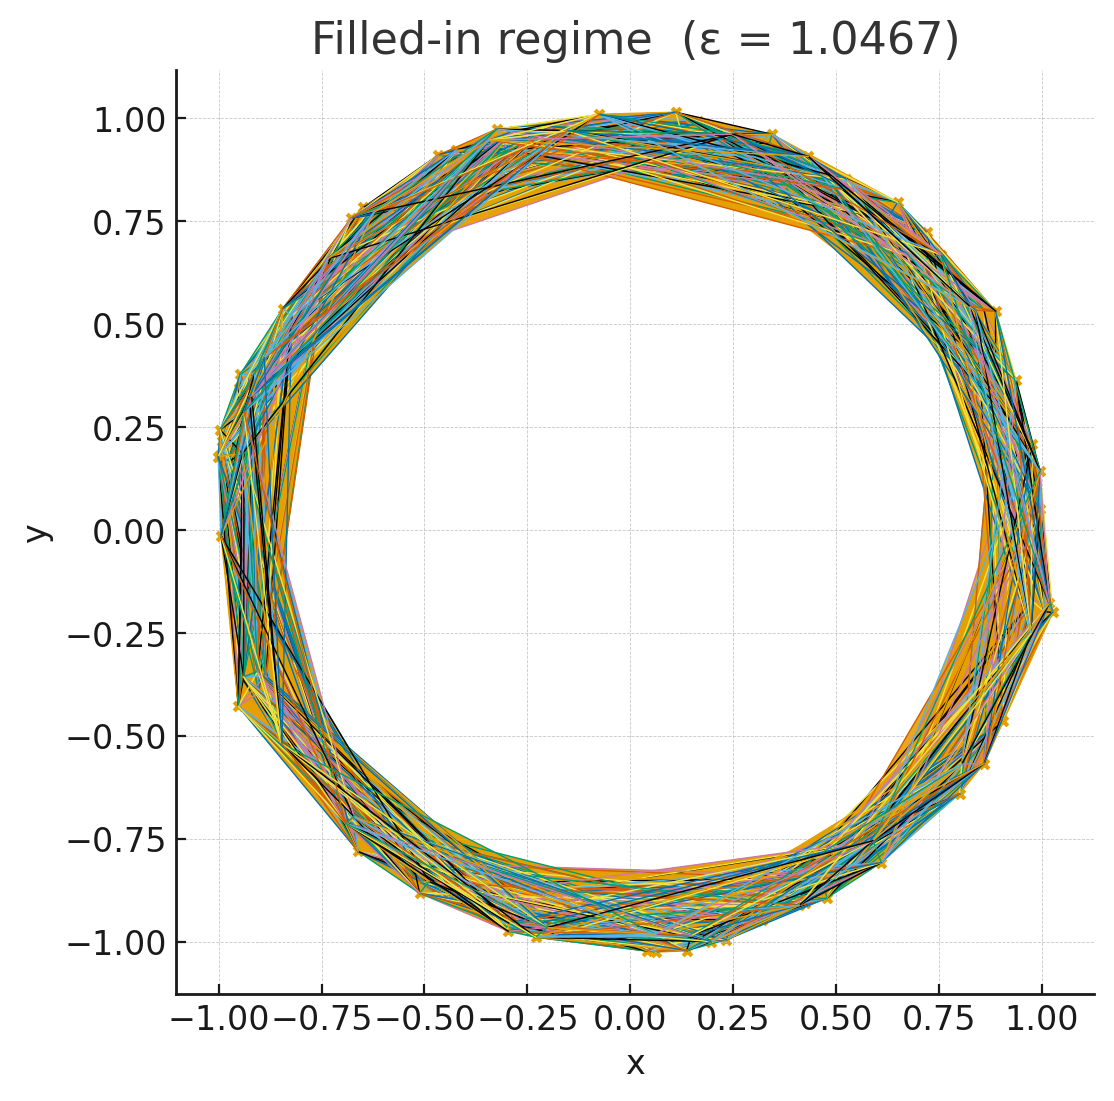



## Code: generate VR snapshots, PD/Barcode (optional), and GIF (optional)

In [ ]:
import numpy as np
from itertools import combinations
import matplotlib.pyplot as plt
from pathlib import Path
import math
try:
    from ripser import ripser
    HAS_RIPSER = True
except Exception:
    HAS_RIPSER = False
OUT_DIR = Path('vr_outputs'); OUT_DIR.mkdir(exist_ok=True)
rng = np.random.default_rng(42)
def make_circle_points(n=160, noise=0.025, r=1.0):
    t = rng.uniform(0, 2*np.pi, n)
    X = np.c_[r*np.cos(t), r*np.sin(t)]
    X += rng.normal(0.0, noise, X.shape)
    return X
def pairwise_distances(X):
    G = X @ X.T
    sq = np.clip(np.diag(G)[:, None] + np.diag(G)[None, :] - 2*G, 0, None)
    return np.sqrt(sq, dtype=float)
def vr_edges_triangles(X, eps, D=None):
    if D is None:
        D = pairwise_distances(X)
    n = len(X)
    edges = [(i,j) for i in range(n) for j in range(i+1, n) if D[i,j] <= eps]
    triangles = []
    for i,j,k in combinations(range(n), 3):
        if D[i,j] <= eps and D[i,k] <= eps and D[j,k] <= eps:
            triangles.append((i,j,k))
    return edges, triangles
def plot_vr(X, edges, triangles, title=None, save_path=None):
    from matplotlib.patches import Polygon
    fig = plt.figure(figsize=(6,6)); ax = fig.add_subplot(111)
    ax.scatter(X[:,0], X[:,1], s=10)
    for (i,j,k) in triangles:
        ax.add_patch(Polygon([X[i], X[j], X[k]], closed=True, alpha=0.15, linewidth=0))
    for (i,j) in edges:
        ax.plot([X[i,0], X[j,0]],[X[i,1], X[j,1]], linewidth=0.5)
    if title: ax.set_title(title)
    ax.set_aspect('equal', adjustable='box'); ax.set_xlabel('x'); ax.set_ylabel('y'); ax.grid(True, linewidth=0.3)
    if save_path is not None:
        fig.savefig(save_path, dpi=200, bbox_inches='tight')
    plt.show(); plt.close(fig)
def percentile_epsilons(D, perc_list):
    vals = D[np.triu_indices_from(D, k=1)]; vals = vals[vals>0]
    return [float(np.percentile(vals, p)) for p in perc_list]


### Generate data + pick ε values

In [ ]:
X = make_circle_points(n=160, noise=0.025)
D = pairwise_distances(X)
percentiles = [6, 14, 35]
eps_list = percentile_epsilons(D, percentiles)
eps_list

### VR snapshots (saved to `vr_outputs/`)

In [ ]:
labels = ['Sparse regime','1-cycle regime','Filled-in regime']
for eps, lab in zip(eps_list, labels):
    edges, tris = vr_edges_triangles(X, eps, D)
    plot_vr(X, edges, tris, title=f"{lab}  (ε = {eps:.4f})", save_path=OUT_DIR/f"vr_{lab.replace(' ','_').lower()}_{eps:.4f}.png")


### (Optional) Persistence diagram + H1 barcode

In [ ]:
if HAS_RIPSER:
    R = ripser(X, maxdim=1)
    dgms = R['dgms']
    # PD
    fig = plt.figure(figsize=(5.5,5.5)); ax = fig.add_subplot(111)
    for d, dgm in enumerate(dgms):
        if len(dgm): ax.scatter(dgm[:,0], dgm[:,1], s=12, label=f'H{d}')
    lim = ax.get_xlim(); ax.plot(lim, lim, linestyle='--', linewidth=1)
    ax.set_xlim(lim); ax.set_ylim(lim)
    ax.set_xlabel('Birth'); ax.set_ylabel('Death'); ax.set_title('Persistence diagram'); ax.legend()
    fig.savefig(OUT_DIR/'persistence_diagram.png', dpi=200, bbox_inches='tight'); plt.show(); plt.close(fig)
    # H1 barcode
    import numpy as np
    H1 = dgms[1] if len(dgms)>1 else np.empty((0,2))
    fig = plt.figure(figsize=(8,3)); ax = fig.add_subplot(111)
    for i,(b,d) in enumerate(H1): ax.plot([b,d],[i,i], linewidth=2)
    ax.set_xlabel('Scale (ε)'); ax.set_ylabel('H1 bars'); ax.set_title('Barcode (H1)')
    fig.savefig(OUT_DIR/'barcode_H1.png', dpi=200, bbox_inches='tight'); plt.show(); plt.close(fig)
else:
    print('ripser not available — skipping persistence plots.')


### (Optional) GIF of VR evolution

In [ ]:
try:
    import imageio.v2 as imageio
    frames_dir = OUT_DIR/'frames'; frames_dir.mkdir(exist_ok=True)
    sweep = percentile_epsilons(D, list(range(4,49,4)))
    files = []
    for k, eps in enumerate(sweep):
        edges, tris = vr_edges_triangles(X, eps, D)
        fp = frames_dir/f'frame_{k:03d}.png'
        plot_vr(X, edges, tris, title=f'Vietoris–Rips complex  (ε = {eps:.4f})', save_path=fp)
        files.append(fp)
    imgs = [imageio.imread(f) for f in files]
    imageio.mimsave(OUT_DIR/'vr_evolution.gif', imgs, fps=6)
    print('Saved:', OUT_DIR/'vr_evolution.gif')
except Exception as e:
    print('GIF creation skipped:', e)
